# Registration-based Automated Matching and Correspondence (RAMAC)

In this guide, we present a comprehensive overview of the `Registration-based Automated Matching and Correspondence (RAMAC) package`, including a detailed explanation of its functionality and a step-by-step guide on how to use it effectively.

## Introduction

The RAMAC algorithm streamlines the process of automating matching and establishing correspondence between longitudinal medical image datasets. It consists of a two-phase sequential pipeline, combining registration and correspondence algorithms to efficiently analyze and thereby establish correspondence.

## Algorithm Overview

The RAMAC algorithm comprises of a two-phase sequential Pipeline:
- Firstly, the algorithm performs <span style="color:blue;">three-dimensional rigid registration</span> is used to register a fixed phantom and a transformed phantom.

- Correspondence of the regions of interest is next established by an <span style="color:#A52A2A;">adaptive Hungarian</span> algorithm.

## Test Case Setup

To illustrate the functionality of the RAMAC package, we provide a test case using a dummy Sheplogan phantom. This phantom serves as the original dataset, with lesion coordinates designated as regions of interest (ROI). Here's how the test case is set up:

- The Sheplogan phantom is generated using the  (termed as original phantom here) using the __[Phantominator](https://github.com/mckib2/phantominator)__ package. lesion cooridnates are placed as region of interest (ROI). 

- The generated phantom is converted to [__SimpleITK (SITK)__](https://simpleitk.readthedocs.io/en/master/) format for compatibility with registration.

- A known transformation is applied to create a transformed phantom and corresponding ROI coordinates.

- The ROI coordinates of the `original` (fixed) and `transformed` (moving) phantoms are stored in _comma-separated values (CSV)_ files for further analysis.
  

## Usage

### Data Generation
- Generate a dummy Sheplogan phantom using Phantominator and convert it to SimpleITK format.
- Apply a known transformation to create a transformed phantom and its corresponding ROI coordinates.
- Save the ROI coordinates in CSV format for later use.

### Registration

- Optionally, preprocess the images to mask out air voxels.
 
- Perform 3D rigid registration between  the `original` (fixed) and `transformed` (moving) phantom using `StepGradientDescent` optimizer with specified parameters. 

- Monitor optimizer progress and convergence at each iteration and output the registered moving image.

- Apply the `registered transformation matrix` to the ROI coordinates of the transformed phantom so as to obtain the 
`registered_coordinates` and save in `result` folder in _comma-separated values (CSV)_ file format.

### Adaptive Hungarian

- Establish correspondence between ROI coordinates of the original and registered images using the adaptive Hungarian algorithm.

- This algorithm takes as input the ROI cooridnate information from the stored _comma-separated values (CSV)_ files.
- Input ROI coordinate information from the CSV files and specify a threshold distance in addition to the one-to-one correspondence for considering lesions as corresponding.

- Visualize the corresponding and unmatched ROI coordinates, and store the results in CSV files. For 'Unmatched' ROI, those are given unique indices too. Store as `correspondence_indices.csv` in the result folder.

<img src="dummy_pic.png" alt="Image Title" style="width: 50%; margin: auto; display: block;">

Above picture shows the correspondence of targets (abnormalities that are tracked) and non-targets (abnormalities that are not of primary focus) between original image (in left) and transformed image or image acquired at later timepoint (in right).

### Plots

- Generate triaxial plots showing corresponding ROI coordinates on original/ fixed, transformed/ moving, and registered phantoms.

- Compare slices interactively for the three images (original, transformed, and registered).

- Plot the correspondence of registered and original phantom coordinates after establishing correspondence.

- Plot of the metric value against number of iterations while conducting registration.

## Conclusion

The RAMAC package offers a robust solution for automating matching and establishing correspondence between  medical image datasets. By integrating registration and correspondence algorithms, it provides an efficient and comprehensive tool for ROI tracking in the longitudinal image data.





Import the libraries and the dependencies from the required scripts

In [1]:
import sys
sys.path.append("../ramac")
#sys.path.append("../result")
! pip install phantominator
from registration import *
from correspondence_csv_input import *
from transform_coordinates import *
from merge_dataframe import *
from phantominator import shepp_logan
from plots import *
from input_transform import *
from preprocessing import mask_air
from utils import *
#import warnings
import scipy
import numpy as np
import SimpleITK as sitk
import pandas as pd
import os

Following the instructions outlined in the `Usage section`, the `test_transform_phantom` script is created. This script exemplifies the process by which a volumetric phantom (referred to as the fixed image) is generated and populated with ROI coordinates. Subsequently, a predetermined transformation is applied, involving a 30&deg; rotation around the X-axis followed by translations of 10 units along the Y-axis and 15 units along the Z-axis, resulting in the creation of the moving image along with its associated coordinates. Importantly, users have the flexibility to utilize their own volumetric image data in this process. The ROI coordinates of both the fixed and moving images are then saved in CSV files within the result folder.

Volumetric registration is applied next and the registered image is achieved. The transformation matrix obtained during registration is applied on the moving image ROI cooridnates to obtain the registered cooridnates which is saved in `result` folder.Adaptive Hungarian algorithm is employed to establish correspondence between the ROI coordinates of the fixed and registered images. This algorithm effectively identifies corresponding ROI pairs and assigns unique nomenclature to unmatched ROI coordinates. The results, including the established correspondence and uniqueness of the ROI sets, are saved as CSV files in the `result` folder. In the provided example, the successful alignment of the registered image with the fixed image post-registration is visually demonstrated through the `triaxial plots`, where two ROIs are highlighted with red dots, indicating perfect alignment between the images.

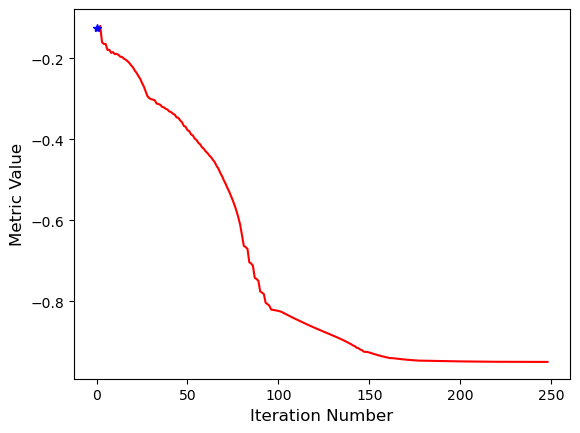

-------
Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 249 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
 Iteration: 250
 Metric value: -0.9495717139470208


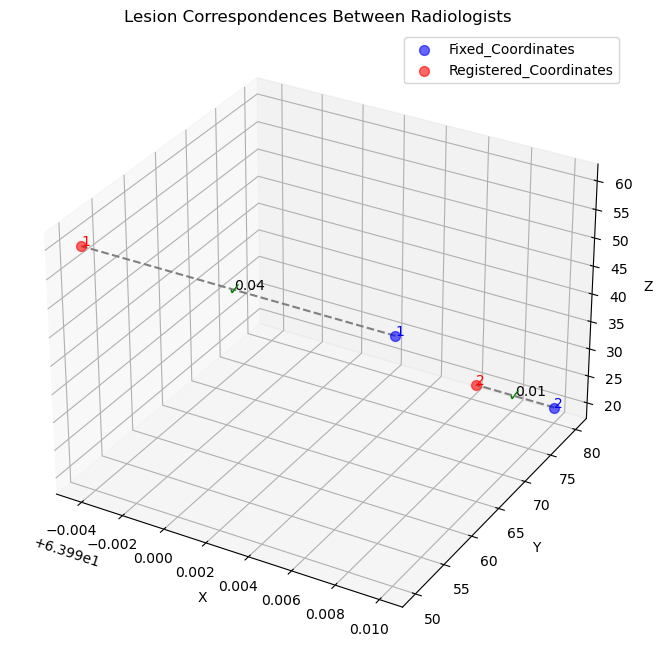

### Fixed Image Interactive Plot

interactive(children=(IntSlider(value=63, description='slice_x', max=127), IntSlider(value=63, description='sl…

### Moving Image Interactive Plot

interactive(children=(IntSlider(value=63, description='slice_x', max=127), IntSlider(value=63, description='sl…

### Registered Image Interactive Plot

interactive(children=(IntSlider(value=63, description='slice_x', max=127), IntSlider(value=63, description='sl…

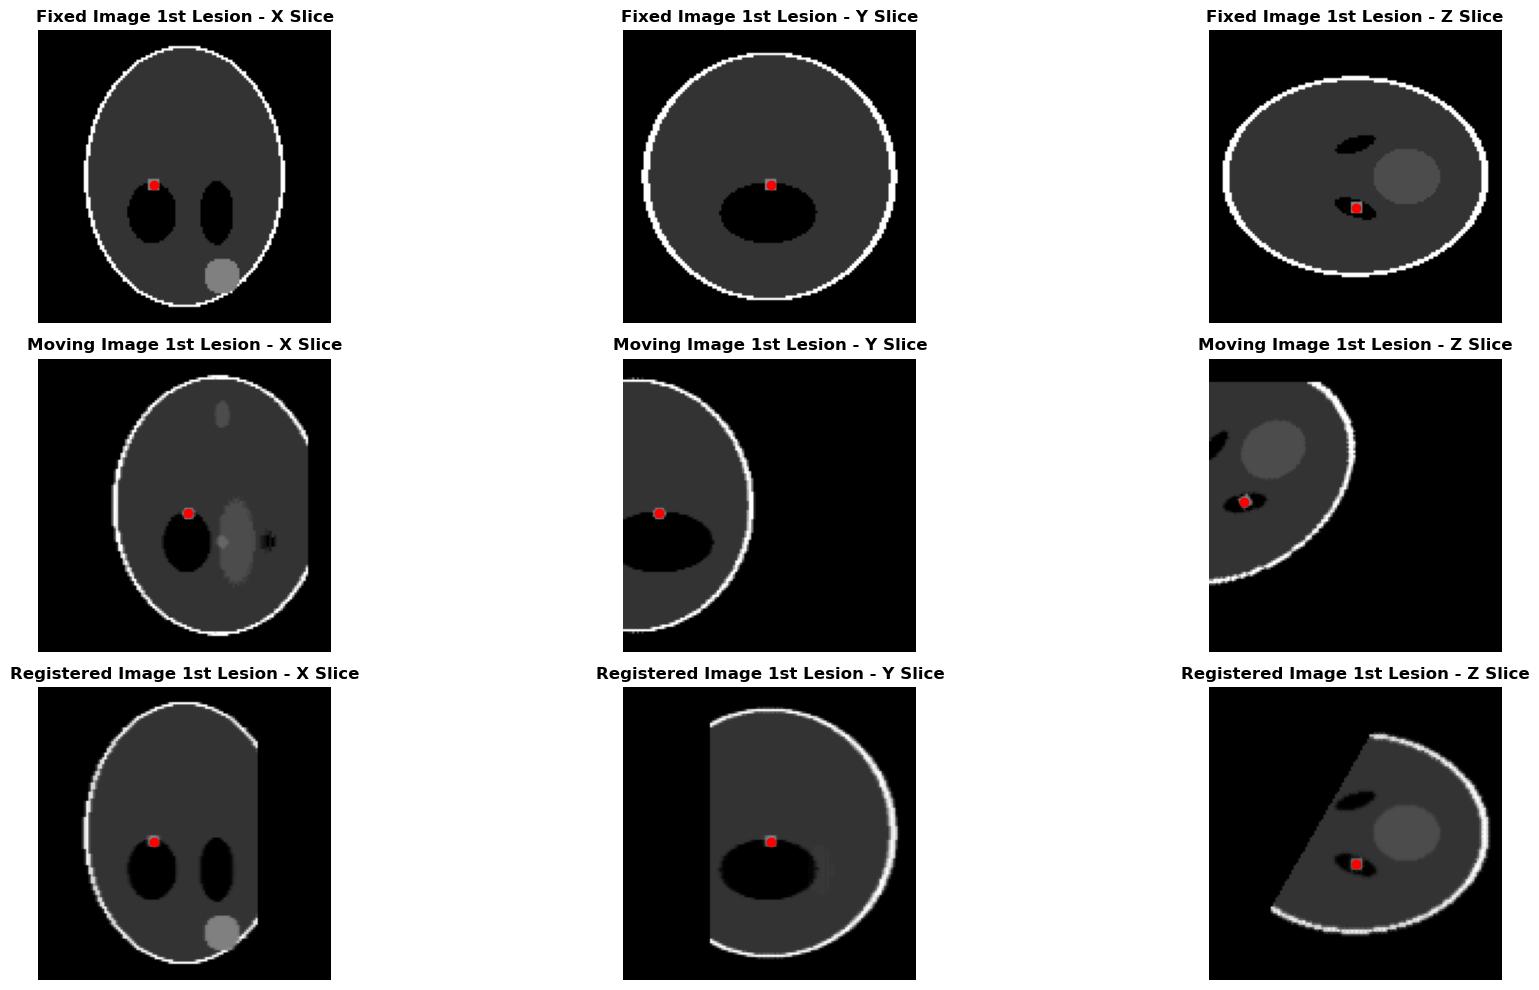

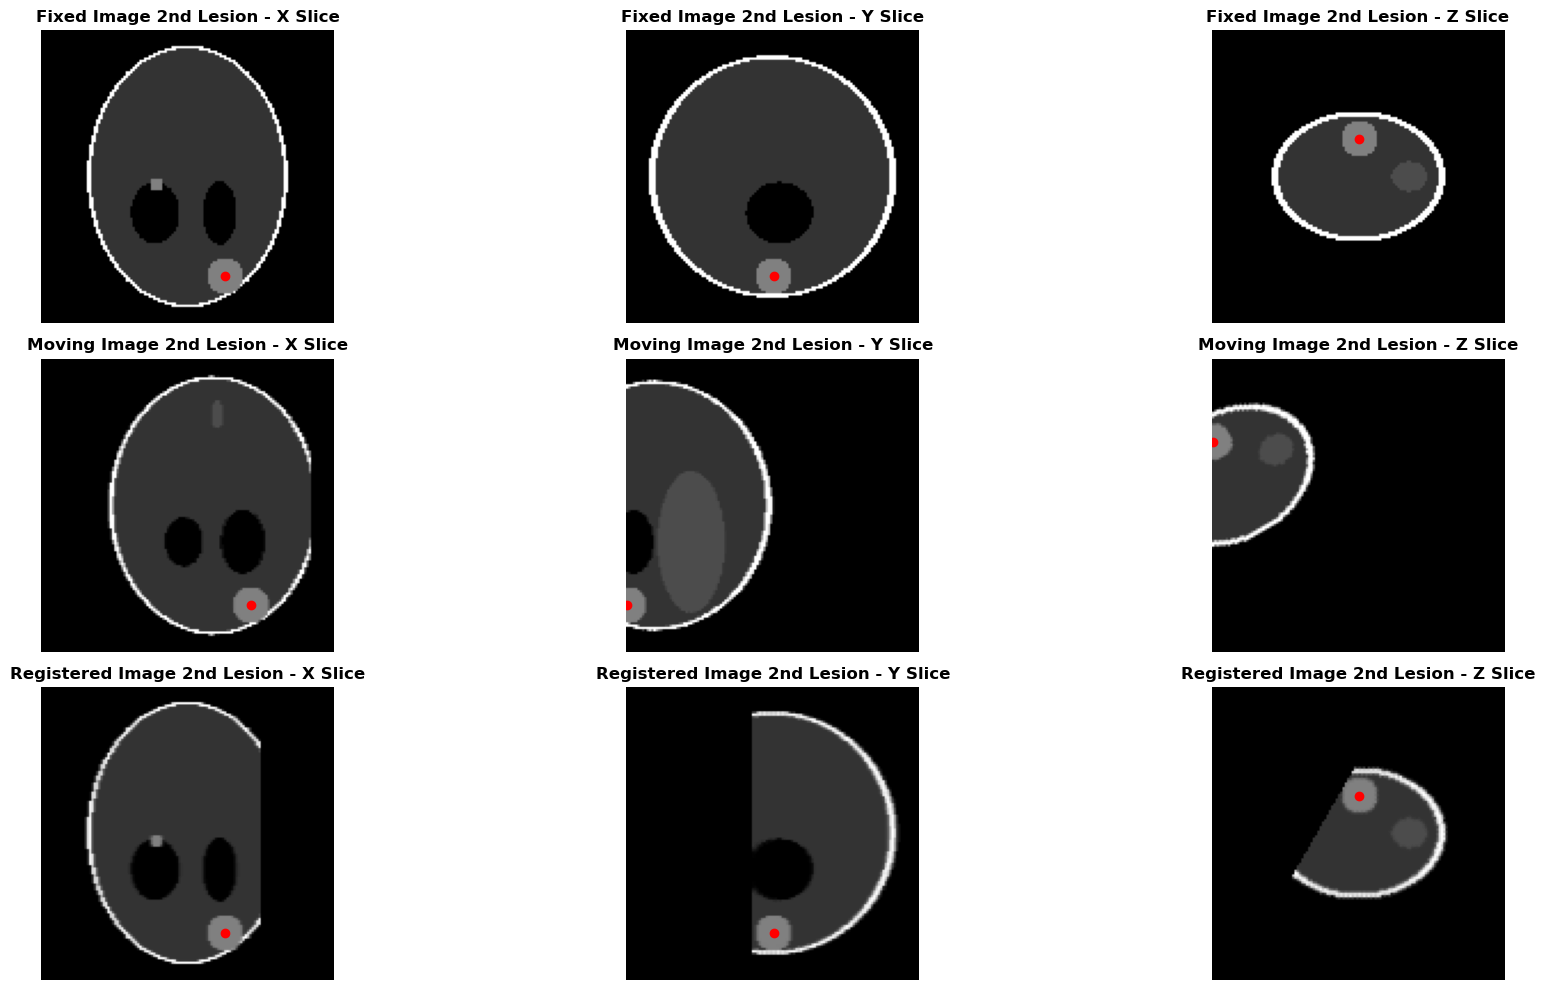

In [2]:
def test_transform_phantom():


    # Create the original phantom
    original_phantom, original_lesions = create_phantom_shepplogan()
    
    # Define rotation and translation parameters 
    rotation_params = (np.pi/6, 0, 0) # Rotate 30 degrees around x axis i.e in yz plane
    translation_params = (0, 10, 15) # Specify translation. Translation is done along y and z axes

    # Transform the phantom to create moving image
    transformed_phantom, transformed_lesions, transformed_lesions_1, transformed_phantom_1 = transform_phantom(original_phantom, original_lesions, rotation_params, translation_params)

    # Print original and transformed lesion coordinates
    print("Original Lesions:", original_lesions)
    print("Transformed Lesions:", transformed_lesions)
    
    
    ## Lesion Index 
    lesion_index = [1,2]

    result_folder = "../result"
    os.makedirs(result_folder, exist_ok=True)  # Create the result folder if it doesn't exist


    # File paths for saving CSV files
    filename_fixed = os.path.join(result_folder, 'fixed_coordinates.csv')
    filename_moving = os.path.join(result_folder, 'moving_coordinates.csv')
    filename_registered = os.path.join(result_folder, 'registered_coordinates.csv')
    filename_correspondence = os.path.join(result_folder, 'correspondence_indices.csv')


    # Save the fixed lesion coordinates
    save_lesion_coordinates(original_lesions, lesion_index, filename_fixed)

    # Save the moving lesion coordinates
    save_lesion_coordinates(transformed_lesions, lesion_index, filename_moving)
    
    ### Perform pre-processing if required
    #original_phantom = mask_air (original_phantom)
    #transformed_phantom = mask_air (transformed_phantom)
    
    ## Apply the 3D rigid registration

    moving_resampled, [init_transform, final_transform] = registration_3d_rigid_gradient_descent(original_phantom, transformed_phantom)

    #final_transform_1 = final_transform.GetInverse()
    
    ## Apply the final transform matrix to the RROI cooridnates of the transformed phantom

    registered_coordinates = create_transformed_dataframe(filename_moving, final_transform)

    save_transformed_dataframe(registered_coordinates, filename_registered)
    
    ### Application of Adaptive Hungarian Algorithm

    threshold = 30
    correspondences, unmatched_names_df1, unmatched_names_df2 = process_lesion_timepoints(filename_fixed, filename_registered, threshold)

    plot_lesion_correspondences_timepoints(filename_fixed, filename_registered)

    final_df = create_final_dataframe_timepoints(correspondences, unmatched_names_df1, unmatched_names_df2, filename_fixed, filename_registered)

    df_transformed = merge_indices(final_df)
    
    ## Save the final correspondence in CSV file

    df_transformed.to_csv(filename_correspondence, index=False)
    
    ### Visualization of the original, transformed and registered phantoms and their corresponding ROIs after registration

    transformed_lesions_rounded = round_coordinates_to_integer(transformed_lesions_1)

    fixed_voxel = transform_physical_to_index(original_phantom, filename_fixed)
    fixed_voxel_tuples = voxel_tuples_from_dataframe(fixed_voxel)

    registered_voxel = transform_physical_to_index(moving_resampled, filename_registered)
    registered_voxel_tuples = voxel_tuples_from_dataframe(registered_voxel)

    compare_slices_interactive(original_phantom, transformed_phantom_1, moving_resampled)
    
    #plot_lesions_1 (original_phantom, transformed_phantom_1, moving_resampled, fixed_voxel_tuples, transformed_lesions_rounded, registered_voxel_tuples)
    
    plot_lesions((original_phantom, fixed_voxel_tuples),
             (transformed_phantom_1, transformed_lesions_rounded),
             (moving_resampled, registered_voxel_tuples))
    
    
# Run test script
test_transform_phantom()